In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats
from sklearn import datasets, preprocessing

df = pd.read_csv("properatti.csv", encoding = 'latin1')

In [2]:
df.columns = ['cod', 'oper', 'tipo', 'local',
       'dir', 'pais', 'ciudad', 'geo_id',
       'lat-lon', 'lat', 'lon', 'precio', 'moneda',
       'p_pesos', 'p_usd', 'sup_m2',
       'sup_cub_m2', 'usd_m2', 'pesos_m2', 'piso',
       'cuartos', 'expensas', 'url', 'descrip', 'tit',
       'foto']

In [3]:
bins_cuartos=[1,3,5,7,10,50]
cats=pd.cut(df.cuartos,bins_cuartos,right=False)
pd.value_counts(cats)

[3, 5)      20504
[1, 3)      19810
[5, 7)       5185
[7, 10)      1363
[10, 50)      528
Name: cuartos, dtype: int64

In [4]:
df['cuartos'].value_counts(normalize=True,dropna=False);
bins_sup=[0,15,30,45,60,100,200,300,500,1000,5000,10000]
cats_sup=pd.cut(df.sup_m2,bins_sup,right=False)

df['local']=df['local'].fillna('Tigre')

## Barrios

In [5]:
df['barrio'] = df['dir'].apply( lambda x: x.split("|")[3])
df['provincia'] = df['dir'].apply( lambda x: x.split("|")[2])

df2 = df.groupby(['barrio','provincia','tipo']) \
       .agg(
                count=('dir', 'size'),
                price_usd_per_m2_mean=('usd_m2','mean'),
                price_usd_per_m2_std=('usd_m2','std'),
                price_mean=('precio','mean'),
                price_std=('precio','std'),
                surface_total_in_m2_mean=('sup_m2','mean'),
                surface_total_in_m2_std=('sup_m2','std')
            
        ) \
       .reset_index() \
       .sort_values(by=['count'], ascending=False);

joined_df = pd.merge(df, df2,  how='inner', left_on=['barrio','provincia','tipo'], right_on = ['barrio','provincia','tipo'])

joined_df['surface_total_in_m2_diff_std'] = abs((joined_df['sup_m2']-joined_df['surface_total_in_m2_mean']) / joined_df['surface_total_in_m2_std'])
joined_df['price_usd_per_m2_diff_std'] = abs((joined_df['usd_m2']-joined_df['price_usd_per_m2_mean']) / joined_df['price_usd_per_m2_std'])

aux_df_delete = joined_df[joined_df['surface_total_in_m2_diff_std']>3]
joined_df.drop(aux_df_delete.index, inplace=True)
aux2_df_delete = joined_df[joined_df['price_usd_per_m2_diff_std']>3]
joined_df.drop(aux2_df_delete.index, inplace=True)

df = joined_df
df.reset_index(inplace=True)

## REGEX

### Antiguedad

In [6]:
patron_estrenos=r'estrenar'
regex_estrenos=re.compile(patron_estrenos, flags=re.IGNORECASE)

patron_antiguos=r'antiguo'
regex_antiguos=re.compile(patron_antiguos, flags=re.IGNORECASE)

estados_list=[]
for i in range(len(df)):
    aux_estrenos=regex_estrenos.findall(df.tit[i])
    aux_antiguos=regex_antiguos.findall(df.tit[i])
    if len(aux_estrenos)>0:
        estados_list.append('estreno')
    else:
        if len(aux_antiguos)>0:
            estados_list.append('antiguo')
        else:
            estados_list.append('promedio')

df['antiguedad']=estados_list

### ambientes

In [7]:
patron_ambientes = r'(\d*)\s*amb+'
regex_amb = re.compile(patron_ambientes, flags=re.IGNORECASE)

lista_amb=[]
aux2=[]
for i in df['tit']:
    aux2=regex_amb.findall(i)
    if len(aux2)>0:
        lista_amb.append(aux2[0])
    else:
        lista_amb.append(np.nan)

In [8]:
pattern_text =r'([a-zA-Z]+)\*samb+'
regex_text=re.compile(pattern_text, flags = re.IGNORECASE)


#Si la palabra extraida es 'dos' o 'tres' y le sigue la palabra ambiente:
lista_amb2=[]
aux_amb2=[]
for i in df.tit:
    aux_amb2=regex_text.findall(i)
    if len(aux_amb2)>0:
        lista_amb2.append(aux_amb2[0].lower())
    else:
        lista_amb2.append(0)

lista_amb2=pd.Series(lista_amb2)


ambientes2=lista_amb2[lista_amb2=='dos']
ambientes3=lista_amb2[lista_amb2=='tres']


for i in range(len(lista_amb2)):
    if lista_amb2[i]=='dos':
        lista_amb[i]=2
    elif lista_amb2[i]=='tres':
        lista_amb[i]=3

df['amb_tit']=lista_amb
df['amb_tit']=pd.to_numeric(df['amb_tit']).fillna(0).astype(np.int64)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### dormitorios

In [9]:
patron_dorm = r'(\d*)\s*dorm+'
regex_dorm = re.compile(patron_dorm, flags=re.IGNORECASE)
lista_dorm=[]
aux3=[]
for i in df['tit']:
    aux3=regex_dorm.findall(i)
    if len(aux3)>0:
        lista_dorm.append(aux3[0])
    else:
        lista_dorm.append(np.nan)

In [10]:
df['dorm_tit']=lista_dorm
df['dorm_tit']=pd.to_numeric(df['dorm_tit']).fillna(0).astype(np.int64)
df['dorm_tit'].value_counts(dropna=False);

#Se le suma 1 a la informacion conseguida de dormitorios para estimar cantidad de ambientes
df['dorm_tit']=df['dorm_tit'].apply(lambda x: x+1 if x>0 else x)

### habitaciones

In [11]:
#Se busca la cantidad de habitaciones en el tit

patron_habit = r'(\d+)\s*habit+'
regex_habit= re.compile(patron_habit, flags=re.IGNORECASE)
lista_habit=[]
aux4=[]

for i in df['tit']:
    aux4=regex_habit.findall(i)
    if len(aux4)>0:
        lista_habit.append(aux4[0])
    else:
        lista_habit.append(np.nan)
        
df['habit_tit']=lista_dorm
df['habit_tit']=pd.to_numeric(df['habit_tit']).fillna(0).astype(np.int64)
df['habit_tit']=df['habit_tit'].apply(lambda x: x+1 if x>0 else x)

### monoambientes

In [12]:
pattern_mono =r'mono+\s*amb+'
regex_mono=re.compile(pattern_mono, flags = re.IGNORECASE)

lista_monoamb=[]
for i in range(len(df.tit)):
    aux_monoamb=regex_mono.findall(df.tit[i])
    if len(aux_monoamb)>0:
        lista_monoamb.append(True)
        lista_amb[i]=1
    else:
        lista_monoamb.append(False)
        
serie_gen=pd.Series(lista_monoamb)

## Amenities

In [13]:
patron_baños=r'(\d+) baÃ±o'
regex_baños=re.compile(patron_baños, flags=re.IGNORECASE)

baños=[];parrillas=[];piletas=[];cocheras=[];en_suite=[]

for i in range(len(df)):
    
#    aux=regex_baños.findall(str(df.descrip[i]))
#   if len(aux)>0:
#        baños.append(int(max(aux)))
#    else:
#        baños.append(1)
        
    if 'parrilla' in str(df.descrip[i]):
        parrillas.append(1)
    else:
        parrillas.append(0)
        
    if 'cochera' in str(df.descrip[i]):
        cocheras.append(1)
    else:
        cocheras.append(0)
    
    if 'pileta' in str(df.descrip[i]) or 'piscina' in str(df.descrip[i]):
        piletas.append(1)
    else:
        piletas.append(0)
    
    if 'en suite'in str(df.descrip[i]):
        en_suite.append(1)
    else:
        en_suite.append(0)

#df['baños']=baños
df['cocheras']=cocheras
df['parrillas']=parrillas
df['piletas']=piletas
df['en_suite']=en_suite

### ambientes-cuartos

In [14]:
df['amb_cuartos']=df['cuartos'].apply(lambda x: x+1 if x>0 else x)

### armado de ambientes

In [15]:
df['amb_tit']=df['amb_tit'].apply(lambda x: np.nan if x==0 else x)
df['amb_tit']=df['amb_tit'].fillna(df['dorm_tit'])
df['amb_tit']=df['amb_tit'].apply(lambda x: np.nan if x==0 else x)
df['amb_tit']=df['amb_tit'].fillna(df['habit_tit'])
df['amb_tit']=df['amb_tit'].apply(lambda x: np.nan if x==0 else x)
df['amb_tit']=df['amb_tit'].fillna(df['amb_cuartos'])
df['amb_tit'].value_counts(dropna=False);

df['amb_tit']=df['amb_tit'].apply(lambda x: 0 if x > 7 else x)

In [16]:
df['amb_tit'].value_counts(dropna=False);
df['amb_tit'].fillna(np.nan).value_counts(dropna=False);

## m2

In [17]:
superificies_no_nulas=df.loc[df['sup_m2'].notnull()&df['sup_cub_m2'].notnull(),['sup_m2','sup_cub_m2']]
factor_m2=superificies_no_nulas['sup_m2']/superificies_no_nulas['sup_cub_m2'].astype(np.int64)
factor_m2.value_counts(normalize=True);

factor_mediana=factor_m2.median()
df['sup_m2']=df['sup_m2'].apply(lambda x: np.nan if x==0 else x)
df['sup_m2']=df['sup_m2'].fillna(df['sup_cub_m2']*factor_mediana)

In [18]:
m2_amb = df[df.amb_tit!=0].groupby(['amb_tit'])['sup_m2'].mean()
df['sup_m2_prom'] = df.groupby(['amb_tit'])['sup_m2'].transform('mean')

In [19]:
#esto tiene sentido rellenarlo?
df['sup_m2']=df['sup_m2'].fillna(df['sup_m2_prom'])

## Precio m2

In [20]:
#llena algo???

df['usd_m2_aux']=df.p_usd/df.sup_m2
df['usd_m2']=df['usd_m2'].fillna(df['usd_m2_aux'])

In [21]:
#Se genera un campo auxiliar con el promedio en usd/m2 por cantidad de ambientes y ubicacion
df['usd_m2_dir']=df.groupby(['amb_tit','provincia','barrio'])['usd_m2'].transform('mean')

In [22]:
#Se completan los nulos de usd/m2 con el promedio en usd/m2 por cantidad de ambientes y ubicacion
df['usd_m2']=df['usd_m2'].fillna(df['usd_m2_dir'])

In [23]:
#Se genera una columna auxiliar de precio total en dolares con la nueva informacion de usd/m2 multiplicada por la nueva informacion de superficie por m2
df['p_usd_aux']=df.usd_m2*df.sup_m2
df['p_usd']=df['p_usd'].fillna(df['p_usd_aux'])

# desafio 2

In [24]:
df = df \
    .drop('cod', 1) \
    .drop('oper', 1) \
    .drop('pais', 1) \
    .drop('p_pesos', 1) \
    .drop('moneda', 1) \
    .drop('pesos_m2', 1) \
    .drop('precio', 1)\
    .drop('url', 1) \
    .drop('expensas', 1)\
    .drop('foto', 1)\
    .drop('dorm_tit', 1)\
    .drop('habit_tit', 1)\
    .drop('amb_cuartos', 1)\
    .drop('sup_m2_prom', 1)\
    .drop('usd_m2_aux', 1)\
    .drop('usd_m2_dir', 1)\
    .drop('p_usd_aux',1)

In [25]:
df['sup_desc_m2']=df['sup_m2']-df['sup_cub_m2']
df['sup_desc_m2']=df['sup_desc_m2'].apply(lambda x: 0 if x < 0 else x)

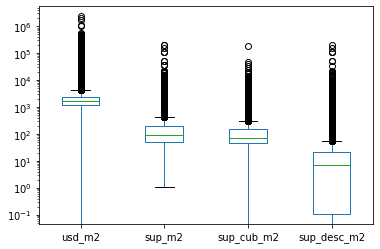

In [26]:
df[['usd_m2','sup_m2','sup_cub_m2','sup_desc_m2']].plot(kind = 'box',logy=True)
plt.show()

Limpieza de outliers box plot

In [27]:
lim_sup_usd=4000
lim_inf_usd=500
lim_sup_m2=400
lim_inf_m2=20
lim_sup_m2_cub=350
lim_inf_m2_cub=15
lim_sup_m2_desc=50
lim_inf_m2_desc=5

df['usd_m2']=df['usd_m2'].apply(lambda x: np.nan if x > lim_sup_usd else x)
df['usd_m2']=df['usd_m2'].apply(lambda x: np.nan if x < lim_inf_usd else x)

df['sup_m2']=df['sup_m2'].apply(lambda x: np.nan if x > lim_sup_m2 else x)
df['sup_m2']=df['sup_m2'].apply(lambda x: np.nan if x < lim_inf_m2 else x)

df['sup_cub_m2']=df['sup_cub_m2'].apply(lambda x: np.nan if x > lim_sup_m2_cub else x)
df['sup_cub_m2']=df['sup_cub_m2'].apply(lambda x: np.nan if x < lim_inf_m2_cub else x)

df['sup_desc_m2']=df['sup_desc_m2'].apply(lambda x: np.nan if x > lim_sup_m2_desc else x)
df['sup_desc_m2']=df['sup_desc_m2'].apply(lambda x: np.nan if x < lim_inf_m2_desc else x)

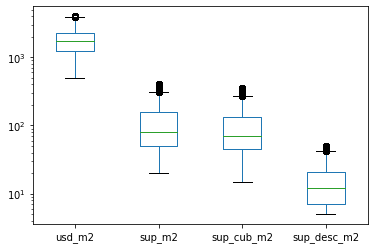

In [28]:
df[['usd_m2','sup_m2','sup_cub_m2','sup_desc_m2']].plot(kind = 'box',logy=True)
plt.show()

In [29]:
df=df[['tipo', 'local', 'dir', 'ciudad','sup_m2','sup_cub_m2','sup_desc_m2','usd_m2','barrio', 'provincia', 'amb_tit','descrip',
       'tit','geo_id', 'lat-lon', 'lat', 'lon','antiguedad','p_usd','en_suite','parrillas','piletas','cocheras']]

In [30]:
df.dropna(subset=['usd_m2'], inplace=True)
df.dropna(subset=['sup_m2'], inplace=True)
df.dropna(subset=['sup_cub_m2'], inplace=True)
df.dropna(subset=['sup_desc_m2'], inplace=True)
df.dropna(subset=['amb_tit'], inplace=True)
df.dropna(subset=['barrio'], inplace=True)
df.dropna(subset=['p_usd'], inplace=True)

Se restringe el df a CABA

In [31]:
df = df.loc[df['ciudad']=='Capital Federal']

In [32]:
df.loc[df['tipo']=='store']=np.nan
df.dropna(subset=['tipo'], inplace=True)

In [33]:
#fig, ax = plt.subplots(figsize=(10,10))       
#sns.heatmap(df.corr() , square=True, annot=True, ax=ax,cmap="YlGnBu", cbar=False);

In [34]:
# Se convierten en "Otros" los barrios sin referencia
df['barrio']=df['barrio'].apply(lambda x: 'Otros' if x=="" else x)

In [35]:
#ver porque no funciona el casteo menor a 5%

#df['barrio_aux']=df.groupby(['barrio'])['barrio'].transform('count')/len(df['barrio'])
#df['barrio']=df['barrio'].apply(lambda x: 'otros' if df['barrio_aux'] < 0.05 else x)

### Dummies

In [36]:
barrio_dummies = pd.get_dummies(df.barrio, prefix='barrio', prefix_sep='_', drop_first=True)
df=pd.concat([df,barrio_dummies],axis=1)

tipo_dummies = pd.get_dummies(df.tipo, prefix='tipo', prefix_sep='_', drop_first=True)
df=pd.concat([df,tipo_dummies],axis=1)

tipo_dummies = pd.get_dummies(df.antiguedad, prefix='antig', prefix_sep='_', drop_first=True)
df=pd.concat([df,tipo_dummies],axis=1)

In [37]:
#df.describe()
#df.corr()

## Distancia al subte

In [38]:
estaciones = pd.read_csv('estaciones-de-subte.csv')

class LatLon:
   def __init__(self, lat, long):
       self.lat = lat 
       self.long = long

    
estaciones = [(LatLon(row.lat,row.long)) for index, row in estaciones.iterrows() ]  

def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)


def min_dist_subte(lat, long):
    aux = min(map(lambda e: haversine_distance(lat, long, e.lat, e.long), estaciones))
    return aux if aux < 100 * 1000 else np.nan

vect_min_dist_subte = np.vectorize(min_dist_subte)
df['dist_subte'] = vect_min_dist_subte(df.lat, df.lon)

# df.reset_index(inplace=True)
# min=[100000]*len(df)
# for i in range(len(df)):
#     for j in range(len(estaciones)):
#         aux=haversine_distance(df.lat[i], df.lon[i], estaciones.lat[j], estaciones.long[j])
#         if aux < min[i]:
#             min[i]=aux
#     if min[i]==100000:
#         min[i]=np.nan
# df['dist_subte']=min


In [39]:
# print(len(df[df['dist_subte'].isnull()]))
# print(len(df[df['dist_subte'].isnull() == False]))
# print(len(df[df.dist_subte!=np.nan]))
# print(len(df))

# df_mean_por_barrio = df[df['dist_subte'].isnull() == False].groupby(['barrio'])['dist_subte'].mean()
# display(df_mean_por_barrio)

# df['dist_subte_aux'] = df_mean_por_barrio
# df['dist_subte'].fillna(df.dist_subte_aux,inplace=True)

df = df[df['dist_subte'].isnull() == False]

In [40]:
#df[df.baños>5]

# Features 1

Variables cuantitativas

In [41]:
y = df['usd_m2']
X = df[['sup_cub_m2', 'sup_desc_m2', 'amb_tit']]

### Split 1

In [42]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)

Se normalizan los features = Xtrain (.fit_transform) y Xtest (.transform)

In [43]:
stdscaler = preprocessing.StandardScaler()
Xtrains = stdscaler.fit_transform(Xtrain)
Xtests = stdscaler.transform(Xtest)

### Regresion lineal 1

MAE: 511.6849258007964
MSE: 407170.6717793021
RMSE: 638.0992648321279
R2: 0.048649848588433575
sup_cub_m2, sup_desc_m2, amb_tit
intercepto:  2259.697130446824
coeficientes:  [  -5.44804477 -133.50262616   25.22759097]


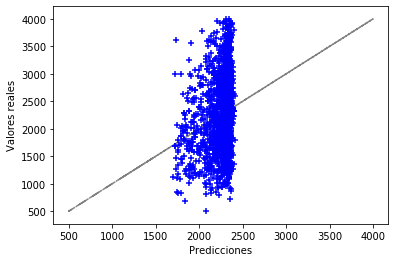

In [44]:
lm = LinearRegression(fit_intercept=True) #instanciacion
lm.fit(Xtrains, ytrain)                   #entrenamiento
ypred = lm.predict(Xtests)                #predicciones

#Metricas
print ('MAE:', metrics.mean_absolute_error(ytest, ypred))
print ('MSE:', metrics.mean_squared_error(ytest, ypred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print ('R2:', metrics.r2_score(ytest, ypred))

print('sup_cub_m2, sup_desc_m2, amb_tit')
print('intercepto: ',lm.intercept_)
print('coeficientes: ',lm.coef_)

plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='b', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

## Ridge 1

RMSE: 638.1039976826471
R2: 0.04863573600437543
alfa:  10.0
sup_cub_m2, sup_desc_m2, amb_tit
intercepto:  2259.697130446824
coeficientes:  [  -5.51551519 -133.21225183   25.15475823]


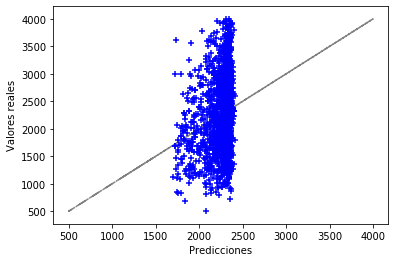

In [45]:
lm_ridge =  linear_model.RidgeCV(alphas=[0.5, 1, 10],cv=5, normalize=False) # instanciacion
modelo_2 = lm_ridge.fit(Xtrains, ytrain)                                    # fiteo
ypred_modelo_2=lm_ridge.predict(Xtests)                                     # predicciones

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_2)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_2))
print('alfa: ',lm_ridge.alpha_)

#Parametros
print('sup_cub_m2, sup_desc_m2, amb_tit')
print('intercepto: ',lm_ridge.intercept_)
print('coeficientes: ',lm_ridge.coef_)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='b', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

## Lasso 1

RMSE: 638.1487143541124
R2: 0.048502393057136994
alfa:  1.0
intercepto:  2259.697130446824
coeficientes:  [  -3.33643651 -132.83824442   22.8448586 ]


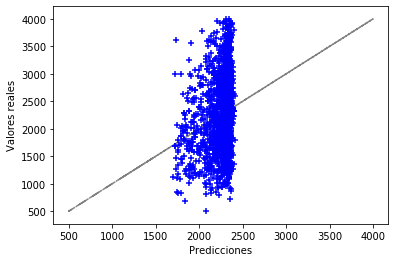

In [46]:
lm_lasso =  linear_model.LassoCV(alphas=[0.5, 1, 10],cv=5, normalize=False) # Instanciacion
modelo_3 = lm_lasso.fit(Xtrains, ytrain)                                    # entrenamiento
ypred_modelo_3=lm_lasso.predict(Xtests)                                     # Predicciones

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_3)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_3))
print('alfa: ',lm_lasso.alpha_)

#Parametros
print('intercepto: ',lm_lasso.intercept_)
print('coeficientes: ',lm_lasso.coef_)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='b', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

## Comparacion de modelos 1

In [47]:
print(" Score Train Lineal: %.4f\n" % lm.score(Xtrains, ytrain),
      "Score Train Ridge : %.4f\n" % lm_ridge.score(Xtrains, ytrain),
      "Score Train Lasso : %.4f\n" %  lm_lasso.score(Xtrains, ytrain))

print(" Score Test Lineal: %.4f\n" % lm.score(Xtests, ytest),
      "Score Test Ridge : %.4f\n" % lm_ridge.score(Xtests, ytest),
      "Score Test Lasso : %.4f\n" %  lm_lasso.score(Xtests, ytest))

 Score Train Lineal: 0.0414
 Score Train Ridge : 0.0414
 Score Train Lasso : 0.0414

 Score Test Lineal: 0.0486
 Score Test Ridge : 0.0486
 Score Test Lasso : 0.0485



## Modelos 2

In [48]:
y = df['usd_m2']
X = df[['barrio_AgronomÃ­a',
       'barrio_Almagro', 'barrio_Balvanera', 'barrio_Barracas',
       'barrio_Barrio Norte', 'barrio_Belgrano', 'barrio_Boca', 'barrio_Boedo',
       'barrio_Caballito', 'barrio_Catalinas', 'barrio_Centro / Microcentro',
       'barrio_Chacarita', 'barrio_Coghlan', 'barrio_Colegiales',
       'barrio_Congreso', 'barrio_ConstituciÃ³n', 'barrio_Flores',
       'barrio_Floresta', 'barrio_Las CaÃ±itas', 'barrio_Liniers',
       'barrio_Mataderos', 'barrio_Monserrat', 'barrio_Monte Castro',
       'barrio_NuÃ±ez', 'barrio_Once', 'barrio_Otros', 'barrio_Palermo',
       'barrio_Parque Avellaneda', 'barrio_Parque Centenario',
       'barrio_Parque Chacabuco', 'barrio_Parque Chas',
       'barrio_Parque Patricios', 'barrio_Paternal', 'barrio_Pompeya',
       'barrio_Puerto Madero', 'barrio_Recoleta', 'barrio_Retiro',
       'barrio_Saavedra', 'barrio_San Cristobal', 'barrio_San NicolÃ¡s',
       'barrio_San Telmo', 'barrio_Tribunales', 'barrio_Velez Sarsfield',
       'barrio_Versalles', 'barrio_Villa Crespo', 'barrio_Villa Devoto',
       'barrio_Villa General Mitre', 'barrio_Villa Lugano',
       'barrio_Villa Luro', 'barrio_Villa Ortuzar', 'barrio_Villa PueyrredÃ³n',
       'barrio_Villa Real', 'barrio_Villa Riachuelo',
       'barrio_Villa Santa Rita', 'barrio_Villa Soldati',
       'barrio_Villa Urquiza', 'barrio_Villa del Parque','tipo_apartment',
       'tipo_house','antig_estreno','antig_promedio','en_suite','parrillas','cocheras','piletas']]

Split y normalizacion 2

In [49]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)
stdscaler = preprocessing.StandardScaler()
Xtrains = stdscaler.fit_transform(Xtrain)
Xtests = stdscaler.transform(Xtest)

## Regresion lineal 2

MAE: 371.0239424253163
MSE: 225302.22529291417
RMSE: 474.6601155489201
R2: 0.4735836321188779
sup_cub_m2, sup_desc_m2, amb_tit, dummies por barrio, tipo y antiguedad


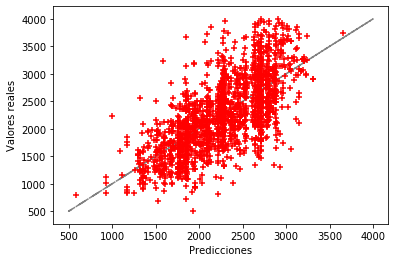

In [50]:
lm = LinearRegression(fit_intercept=True) #instanciacion
lm.fit(Xtrains, ytrain)                   #entrenamiento
ypred = lm.predict(Xtests)                #predicciones

#Metricas
print ('MAE:', metrics.mean_absolute_error(ytest, ypred))
print ('MSE:', metrics.mean_squared_error(ytest, ypred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print ('R2:', metrics.r2_score(ytest, ypred))

print('sup_cub_m2, sup_desc_m2, amb_tit, dummies por barrio, tipo y antiguedad')
#print('intercepto: ',lm.intercept_)
#print('coeficientes: ',lm.coef_)

plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

## Ridge 2

RMSE: 474.66133003221245
R2: 0.4735809382978444
alfa:  1.0
sup_cub_m2, sup_desc_m2, amb_tit


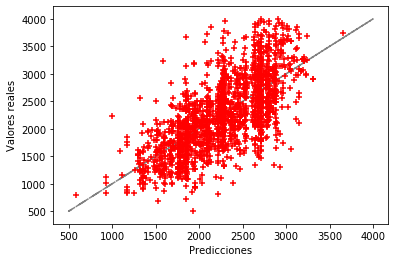

In [51]:
lm_ridge =  linear_model.RidgeCV(alphas=[0.5, 1, 10],cv=5, normalize=False) # instanciacion
modelo_2 = lm_ridge.fit(Xtrains, ytrain)                                    # fiteo
ypred_modelo_2=lm_ridge.predict(Xtests)                                     # predicciones

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_2)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_2))
print('alfa: ',lm_ridge.alpha_)

#Parametros
print('sup_cub_m2, sup_desc_m2, amb_tit')
#print('intercepto: ',lm_ridge.intercept_)
#print('coeficientes: ',lm_ridge.coef_)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

## Lasso 2

RMSE: 474.707673186646
R2: 0.4734781403268825
alfa:  0.5


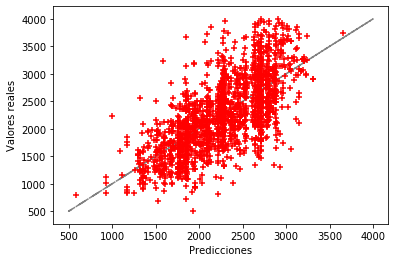

In [52]:
lm_lasso =  linear_model.LassoCV(alphas=[0.5, 1, 10],cv=5, normalize=False) # Instanciacion
modelo_3 = lm_lasso.fit(Xtrains, ytrain)                                    # entrenamiento
ypred_modelo_3=lm_lasso.predict(Xtests)                                     # Predicciones

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_3)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_3))
print('alfa: ',lm_lasso.alpha_)

#Parametros
#print('intercepto: ',lm_lasso.intercept_)
#print('coeficientes: ',lm_lasso.coef_)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

Comparacion metricas

In [53]:
print(" Score Train Lineal: %.4f\n" % lm.score(Xtrains, ytrain),
      "Score Train Ridge : %.4f\n" % lm_ridge.score(Xtrains, ytrain),
      "Score Train Lasso : %.4f\n" %  lm_lasso.score(Xtrains, ytrain))

print(" Score Test Lineal: %.4f\n" % lm.score(Xtests, ytest),
      "Score Test Ridge : %.4f\n" % lm_ridge.score(Xtests, ytest),
      "Score Test Lasso : %.4f\n" %  lm_lasso.score(Xtests, ytest))

 Score Train Lineal: 0.4878
 Score Train Ridge : 0.4878
 Score Train Lasso : 0.4877

 Score Test Lineal: 0.4736
 Score Test Ridge : 0.4736
 Score Test Lasso : 0.4735



## Stats model: features selection

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


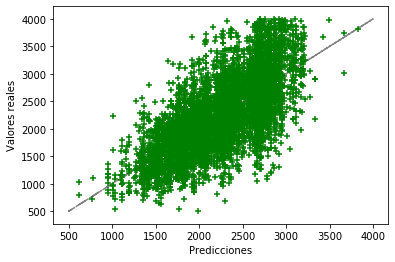

EMC: 217205.5450987722
                            OLS Regression Results                            
Dep. Variable:                 usd_m2   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     103.9
Date:                Mon, 04 May 2020   Prob (F-statistic):               0.00
Time:                        14:11:53   Log-Likelihood:                -54622.
No. Observations:                7222   AIC:                         1.094e+05
Df Residuals:                    7156   BIC:                         1.098e+05
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [54]:
X = df[['barrio_AgronomÃ­a',
       'barrio_Almagro', 'barrio_Balvanera', 'barrio_Barracas',
       'barrio_Barrio Norte', 'barrio_Belgrano', 'barrio_Boca', 'barrio_Boedo',
       'barrio_Caballito', 'barrio_Catalinas', 'barrio_Centro / Microcentro',
       'barrio_Chacarita', 'barrio_Coghlan', 'barrio_Colegiales',
       'barrio_Congreso', 'barrio_ConstituciÃ³n', 'barrio_Flores',
       'barrio_Floresta', 'barrio_Las CaÃ±itas', 'barrio_Liniers',
       'barrio_Mataderos', 'barrio_Monserrat', 'barrio_Monte Castro',
       'barrio_NuÃ±ez', 'barrio_Once', 'barrio_Otros', 'barrio_Palermo',
       'barrio_Parque Avellaneda', 'barrio_Parque Centenario',
       'barrio_Parque Chacabuco', 'barrio_Parque Chas',
       'barrio_Parque Patricios', 'barrio_Paternal', 'barrio_Pompeya',
       'barrio_Puerto Madero', 'barrio_Recoleta', 'barrio_Retiro',
       'barrio_Saavedra', 'barrio_San Cristobal', 'barrio_San NicolÃ¡s',
       'barrio_San Telmo', 'barrio_Tribunales', 'barrio_Velez Sarsfield',
       'barrio_Versalles', 'barrio_Villa Crespo', 'barrio_Villa Devoto',
       'barrio_Villa General Mitre', 'barrio_Villa Lugano',
       'barrio_Villa Luro', 'barrio_Villa Ortuzar', 'barrio_Villa PueyrredÃ³n',
       'barrio_Villa Real', 'barrio_Villa Riachuelo',
       'barrio_Villa Santa Rita', 'barrio_Villa Soldati',
       'barrio_Villa Urquiza', 'barrio_Villa del Parque','tipo_apartment',
       'tipo_house','antig_estreno','antig_promedio','en_suite','parrillas','cocheras','piletas']]

y = df['usd_m2']

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='g', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

## FEATURES 3

Descarte de 34 columnas (por p values > 5% en stats)

In [55]:
X = df[['barrio_Barrio Norte', 'barrio_Belgrano', 'barrio_Boca',
       'barrio_Caballito', 'barrio_Coghlan', 'barrio_Colegiales',
       'barrio_Congreso', 'barrio_ConstituciÃ³n', 'barrio_Las CaÃ±itas',
        'barrio_Mataderos','barrio_NuÃ±ez', 'barrio_Palermo',
       'barrio_Parque Avellaneda', 'barrio_Pompeya',
       'barrio_Puerto Madero', 'barrio_Recoleta', 'barrio_Retiro',
       'barrio_Saavedra','barrio_Villa Crespo',
        'barrio_Villa Lugano', 'barrio_Villa Ortuzar', 'barrio_Villa Soldati',
       'barrio_Villa Urquiza','tipo_apartment','tipo_house','antig_estreno','antig_promedio','en_suite','cocheras','piletas']]
y = df['usd_m2']

In [56]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)
stdscaler = preprocessing.StandardScaler()
Xtrains = stdscaler.fit_transform(Xtrain)
Xtests = stdscaler.transform(Xtest)

## Regresion lineal 3

MAE: 375.16827754319127
MSE: 229480.0702366385
RMSE: 479.04078139197975
R2: 0.463822139714679
coeficientes:  [150.01286594 221.75601078 -27.1621871  110.54528064  48.09789929
  55.26019565 -22.27352346 -23.82457191  73.2546035  -33.15157969
 101.55751899 244.65885835 -14.01701583 -27.79030388  43.04626136
 184.04496878  41.96636991  49.49072941  56.32790123 -47.45821832
  19.67576257 -33.87041104  85.45503354  93.32196822 -37.00871348
 106.22453309  75.62560707  30.77670212  66.13416819  74.94753457]


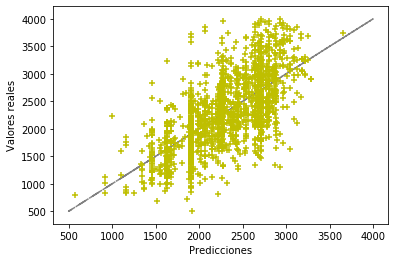

In [57]:
lm = LinearRegression(fit_intercept=True)    #Instanciacion
lm.fit(Xtrains, ytrain)                      #Entrenamiento
ypred = lm.predict(Xtests)                   #Prediccion con el set de testeo

#Metricas
print ('MAE:', metrics.mean_absolute_error(ytest, ypred))
print ('MSE:', metrics.mean_squared_error(ytest, ypred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print ('R2:', metrics.r2_score(ytest, ypred))

#Parametros
#print('intercepto: ',lm.intercept_)
print('coeficientes: ',lm.coef_)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='y', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

## Ridge 3

RMSE: 479.0705626635432
R2: 0.4637554708403814
alfa:  10.0
coeficientes:  [149.41158753 220.95675463 -27.22522498 109.92323366  47.85945288
  54.99542143 -22.45637884 -23.95791088  73.00605103 -33.23339542
 101.14640827 243.80665312 -14.04561103 -27.81755906  42.92032353
 183.34089864  41.66425525  49.19730638  55.98103435 -47.48757987
  19.57490141 -33.86050275  84.98311849  93.41634972 -37.04012663
 102.15006446  71.63012772  30.90507286  66.12762243  74.9089485 ]


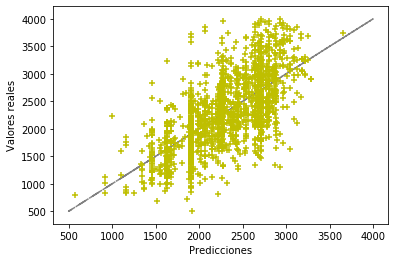

In [58]:
lm_ridge =  linear_model.RidgeCV(alphas=[0.5, 1, 10],cv=5, normalize=False)  #Instanciacion
modelo_2 = lm_ridge.fit(Xtrains, ytrain)                                     #Entrenamiento
ypred_modelo_2=lm_ridge.predict(Xtests)                                      #Prediccion con el set de testeo

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_2)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_2))
print('alfa: ',lm_ridge.alpha_)

#Parametros
#print('intercepto: ',lm_ridge.intercept_)
print('coeficientes: ',lm_ridge.coef_)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='y', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

## Lasso 3

RMSE: 479.17468550812134
R2: 0.46352234704678474
alfa:  0.5
coeficientes:  [148.96573041 220.70064028 -26.8425269  109.41313741  47.39672301
  54.52418942 -22.26483008 -23.65859358  72.59424868 -32.88669375
 100.72197581 243.53106931 -13.60344208 -27.44643304  42.48464181
 182.94637554  40.97060734  48.6836917   55.4594632  -47.15967776
  19.07771064 -33.46233055  84.52610956  93.61694446 -36.61673388
  93.51565626  62.88040261  30.68211516  66.01356394  74.77962549]


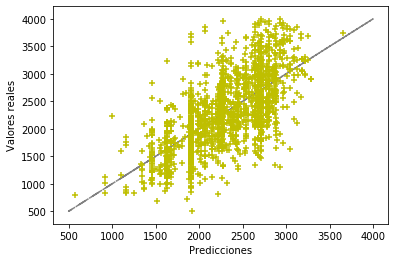

In [59]:
lm_lasso =  linear_model.LassoCV(alphas=[0.5, 1, 10],cv=5, normalize=False)  #Instanciacion
modelo_3 = lm_lasso.fit(Xtrains, ytrain)                                     #Entrenamiento
ypred_modelo_3=lm_lasso.predict(Xtests)                                      #Prediccion con el set de testeo

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_3)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_3))
print('alfa: ',lm_lasso.alpha_)

#Parametros
#print('intercepto: ',lm_lasso.intercept_)
print('coeficientes: ',lm_lasso.coef_)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(ypred, ytest, s=30, c='y', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

In [60]:
print(" Score Train Lineal: %.4f\n" % lm.score(Xtrains, ytrain),
      "Score Train Ridge : %.4f\n" % lm_ridge.score(Xtrains, ytrain),
      "Score Train Lasso : %.4f\n" %  lm_lasso.score(Xtrains, ytrain))

print(" Score Test Lineal: %.4f\n" % lm.score(Xtests, ytest),
      "Score Test Ridge : %.4f\n" % lm_ridge.score(Xtests, ytest),
      "Score Test Lasso : %.4f\n" %  lm_lasso.score(Xtests, ytest))

 Score Train Lineal: 0.4725
 Score Train Ridge : 0.4725
 Score Train Lasso : 0.4725

 Score Test Lineal: 0.4638
 Score Test Ridge : 0.4638
 Score Test Lasso : 0.4635



## Ridge sin CV

In [61]:
ridge = linear_model.Ridge(alpha=0.5, normalize=False)
ridge_model = ridge.fit(Xtrains, ytrain)
predictions = ridge_model.predict(Xtests)

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, predictions)))
print ('R2:', metrics.r2_score(ytest, predictions))

RMSE: 479.0421546495753
R2: 0.46381906560740793


## Lasso sin CV

In [62]:
lasso = linear_model.Lasso(alpha=0.5, normalize=True)
lasso_model =lasso.fit(Xtrains, ytrain)
predictions2 = lasso_model.predict(Xtests)

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, predictions2)))
print ('R2:', metrics.r2_score(ytest, predictions2))

RMSE: 525.4371162544795
R2: 0.3549321485859154


## Agregado dist subte y EPH

In [63]:
df2 = pd.read_excel('eph2.xlsx')
df3=pd.merge(df,df2,left_on='barrio',right_on='Barrio')
df=df3

In [64]:
X = df[['barrio_Barrio Norte', 'barrio_Belgrano', 'barrio_Boca',
       'barrio_Caballito', 'barrio_Coghlan', 'barrio_Colegiales',
       'barrio_Congreso', 'barrio_ConstituciÃ³n', 'barrio_Las CaÃ±itas',
        'barrio_Mataderos','barrio_NuÃ±ez', 'barrio_Palermo',
       'barrio_Parque Avellaneda', 'barrio_Pompeya',
       'barrio_Puerto Madero', 'barrio_Recoleta', 'barrio_Retiro',
       'barrio_Saavedra','barrio_Villa Crespo',
        'barrio_Villa Lugano', 'barrio_Villa Ortuzar', 'barrio_Villa Soldati',
       'barrio_Villa Urquiza','tipo_apartment','tipo_house','antig_estreno','antig_promedio','en_suite','cocheras','piletas',
        'iprom','imax','dist_subte']]
y = df['usd_m2']

## Regresion lineal 4

In [65]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)
stdscaler = preprocessing.StandardScaler()
Xtrains = stdscaler.fit_transform(Xtrain)
Xtests = stdscaler.transform(Xtest)

In [66]:
lm = LinearRegression(fit_intercept=True) #Instanciacion
lm.fit(Xtrains, ytrain) #Entrenamiento
ypred = lm.predict(Xtests) #Prediccion con el set de testeo

#Metricas
print ('MAE:', metrics.mean_absolute_error(ytest, ypred))
print ('MSE:', metrics.mean_squared_error(ytest, ypred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print ('R2:', metrics.r2_score(ytest, ypred))

#Parametros
#print('intercepto: ',lm.intercept_)
#print('coeficientes: ',lm.coef_)

MAE: 370.0040639096102
MSE: 218589.27340561792
RMSE: 467.5353178163313
R2: 0.4772511169223551


### Ridge 4

In [67]:
lm_ridge =  linear_model.RidgeCV(alphas=[0.5, 1, 10],cv=5, normalize=False) #Instanciacion
modelo_2 = lm_ridge.fit(Xtrains, ytrain)   #Entrenamiento
ypred_modelo_2=lm_ridge.predict(Xtests)   #Prediccion con el set de testeo

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_2)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_2))

#Alfa
print('alfa: ',lm_ridge.alpha_)

#Parametros
print('intercepto: ',lm_ridge.intercept_)
print('coeficientes: ',lm_ridge.coef_)

RMSE: 467.54710548000907
R2: 0.4772247571353362
alfa:  10.0
intercepto:  2256.0307621379166
coeficientes:  [140.94260241 221.18392686 -30.53437945  93.56622855  50.70066847
  54.08973876 -19.66338387 -17.47650138  78.95907678 -34.30490236
 103.41406809 215.93612515 -15.52601459 -30.63788232  31.90577059
 162.92926369  54.01717159  59.26432452  58.58356347 -46.53307945
  24.2822431  -31.58162064  89.36301061  88.83223113 -35.17647102
 103.50375114  76.57062802  33.7220597   66.42334592  77.29241912
 -16.9799496   38.47657576   4.31308898]


## Lasso 4

In [68]:
lm_lasso =  linear_model.LassoCV(alphas=[0.5, 1, 10],cv=5, normalize=False)  #Instanciacion
modelo_3 = lm_lasso.fit(Xtrains, ytrain)  #Entrenamiento
ypred_modelo_3=lm_lasso.predict(Xtests)   #Prediccion con el set de testeo

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_3)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_3))

#Alfa
print('alfa: ',lm_lasso.alpha_)

#Parametros
#print('intercepto: ',lm_lasso.intercept_)
print('coeficientes: ',lm_lasso.coef_)

RMSE: 467.47408636428236
R2: 0.47738803311207
alfa:  0.5
coeficientes:  [139.53839809 220.48345117 -29.89685907  92.51466069  50.0961863
  53.26847943 -19.55344879 -17.47839957  78.28658319 -33.6118345
 103.16530366 215.60266023 -14.91279406 -30.26662199  31.30980421
 162.59071912  52.98522779  59.00766285  57.97633989 -45.92671816
  23.60692689 -31.09663242  88.8155037   88.76697046 -34.71517927
  94.69020539  67.59961554  33.51290263  66.25863173  77.18001424
 -15.45732675  38.59090387   3.05120062]


## Resumen 4

In [69]:
print(" Score Train Lineal: %.4f\n" % lm.score(Xtrains, ytrain),
      "Score Train Ridge : %.4f\n" % lm_ridge.score(Xtrains, ytrain),
      "Score Train Lasso : %.4f\n" %  lm_lasso.score(Xtrains, ytrain))

print(" Score Test Lineal: %.4f\n" % lm.score(Xtests, ytest),
      "Score Test Ridge : %.4f\n" % lm_ridge.score(Xtests, ytest),
      "Score Test Lasso : %.4f\n" %  lm_lasso.score(Xtests, ytest))

 Score Train Lineal: 0.4680
 Score Train Ridge : 0.4680
 Score Train Lasso : 0.4680

 Score Test Lineal: 0.4773
 Score Test Ridge : 0.4772
 Score Test Lasso : 0.4774



Chequeo p values (las tres nuevas columnas de eph y subte tienen p > 5%)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


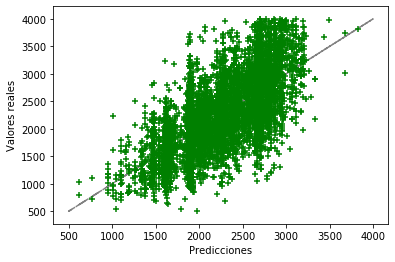

EMC: 223260.49152432542
                            OLS Regression Results                            
Dep. Variable:                 usd_m2   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     194.1
Date:                Mon, 04 May 2020   Prob (F-statistic):               0.00
Time:                        14:11:54   Log-Likelihood:                -54721.
No. Observations:                7222   AIC:                         1.095e+05
Df Residuals:                    7188   BIC:                         1.097e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------


In [70]:
X = df[['barrio_Barrio Norte', 'barrio_Belgrano', 'barrio_Boca',
       'barrio_Caballito', 'barrio_Coghlan', 'barrio_Colegiales',
       'barrio_Congreso', 'barrio_ConstituciÃ³n', 'barrio_Las CaÃ±itas',
        'barrio_Mataderos','barrio_NuÃ±ez', 'barrio_Palermo',
       'barrio_Parque Avellaneda', 'barrio_Pompeya',
       'barrio_Puerto Madero', 'barrio_Recoleta', 'barrio_Retiro',
       'barrio_Saavedra','barrio_Villa Crespo',
        'barrio_Villa Lugano', 'barrio_Villa Ortuzar', 'barrio_Villa Soldati',
       'barrio_Villa Urquiza','tipo_apartment','tipo_house','antig_estreno',
        'antig_promedio','en_suite','cocheras','piletas',
        'iprom','imax','dist_subte']]
y = df['usd_m2']
# Tenemos que agregar explícitamente a una constante:


X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='g', marker='+', zorder=10)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

## Modelo definitivo + proyecciones

In [71]:
X = df[['barrio_Barrio Norte', 'barrio_Belgrano', 'barrio_Boca',
       'barrio_Caballito', 'barrio_Coghlan', 'barrio_Colegiales',
       'barrio_Congreso', 'barrio_ConstituciÃ³n', 'barrio_Las CaÃ±itas',
        'barrio_Mataderos','barrio_NuÃ±ez', 'barrio_Palermo',
       'barrio_Parque Avellaneda', 'barrio_Pompeya',
       'barrio_Puerto Madero', 'barrio_Recoleta', 'barrio_Retiro',
       'barrio_Saavedra','barrio_Villa Crespo',
        'barrio_Villa Lugano', 'barrio_Villa Ortuzar', 'barrio_Villa Soldati',
       'barrio_Villa Urquiza','tipo_apartment','tipo_house','antig_estreno','antig_promedio','en_suite','cocheras','piletas']]
y = df['usd_m2']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)
stdscaler = preprocessing.StandardScaler()
Xtrains = stdscaler.fit_transform(Xtrain)
Xtests = stdscaler.transform(Xtest)

lm_ridge =  linear_model.RidgeCV(alphas=[0.5, 1, 10],cv=5, normalize=False) #Instanciacion
modelo_2 = lm_ridge.fit(Xtrains, ytrain)   #Entrenamiento
ypred_modelo_2=lm_ridge.predict(Xtests)   #Prediccion con el set de testeo

#Metricas
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred_modelo_2)))
print ('R2:', metrics.r2_score(ytest, ypred_modelo_2))

RMSE: 467.2824114265242
R2: 0.477816510680488


In [72]:
df_proy = df[['barrio_Barrio Norte', 'barrio_Belgrano', 'barrio_Boca',
       'barrio_Caballito', 'barrio_Coghlan', 'barrio_Colegiales',
       'barrio_Congreso', 'barrio_ConstituciÃ³n', 'barrio_Las CaÃ±itas',
        'barrio_Mataderos','barrio_NuÃ±ez', 'barrio_Palermo',
       'barrio_Parque Avellaneda', 'barrio_Pompeya',
       'barrio_Puerto Madero', 'barrio_Recoleta', 'barrio_Retiro',
       'barrio_Saavedra','barrio_Villa Crespo',
        'barrio_Villa Lugano', 'barrio_Villa Ortuzar', 'barrio_Villa Soldati',
       'barrio_Villa Urquiza','tipo_apartment','tipo_house','antig_estreno','antig_promedio','en_suite','cocheras','piletas','usd_m2']].sample(100)

X_proy=df_proy[['barrio_Barrio Norte', 'barrio_Belgrano', 'barrio_Boca',
       'barrio_Caballito', 'barrio_Coghlan', 'barrio_Colegiales',
       'barrio_Congreso', 'barrio_ConstituciÃ³n', 'barrio_Las CaÃ±itas',
        'barrio_Mataderos','barrio_NuÃ±ez', 'barrio_Palermo',
       'barrio_Parque Avellaneda', 'barrio_Pompeya',
       'barrio_Puerto Madero', 'barrio_Recoleta', 'barrio_Retiro',
       'barrio_Saavedra','barrio_Villa Crespo',
        'barrio_Villa Lugano', 'barrio_Villa Ortuzar', 'barrio_Villa Soldati',
       'barrio_Villa Urquiza','tipo_apartment','tipo_house','antig_estreno','antig_promedio','en_suite','cocheras','piletas']]
y_proy = df_proy['usd_m2']

#Xtrain, Xtest, ytrain, ytest = train_test_split(X_sample, y_sample, test_size=0.5, random_state=1)
stdscaler = preprocessing.StandardScaler()
Xtrains = stdscaler.fit_transform(X_proy)
#Xtests = stdscaler.transform(Xtest)

y_proyecciones=lm_ridge.predict(X_proy)

In [73]:
y_proyecciones = list (y_proyecciones)
y_proy = list(y_proy)

In [74]:
diferencias=[]
for i in range(len(y_proyecciones)):
    dif=y_proyecciones[i]-y_proy[i]
    diferencias.append(dif)
df_proy['inversiones']=diferencias
df_proy.sort_values(['inversiones'], ascending = False,inplace=True)

In [77]:
proy_final=df_proy.head(100)
df_proy.head(100)

,barrio_Barrio Norte,barrio_Belgrano,barrio_Boca,barrio_Caballito,barrio_Coghlan,barrio_Colegiales,barrio_Congreso,barrio_ConstituciÃ³n,barrio_Las CaÃ±itas,barrio_Mataderos,...,barrio_Villa Urquiza,tipo_apartment,tipo_house,antig_estreno,antig_promedio,en_suite,cocheras,piletas,usd_m2,inversiones
2107,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0.0,0.0,0.0,1091.228893,1331.202589
1634,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0.0,0.0,0.0,1140.350877,1282.080605
7141,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0.0,0.0,0.0,1193.076923,1183.677840
2214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.0,0.0,0.0,1155.279503,1178.488962
6321,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0.0,0.0,0.0,1136.363636,1169.020433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0.0,0.0,0.0,2921.568627,-499.137146
6907,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0.0,1.0,1.0,3122.600000,-549.976641
3304,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0.0,0.0,0.0,3145.833333,-723.401852
4592,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1.0,1.0,0.0,3828.828829,-1123.492228


(array([0.00231344, 0.00694032, 0.01696524, 0.03547277, 0.06169177,
        0.11490091, 0.1442045 , 0.16271203, 0.20049824, 0.26681689,
        0.32696636, 0.37631977, 0.35781224, 0.39251386, 0.39097156,
        0.40253877, 0.37709092, 0.32311062, 0.27375721, 0.25524968,
        0.20358283, 0.19972709, 0.1704235 , 0.12878156, 0.09485109,
        0.07711471, 0.06477635, 0.05012456, 0.04781112, 0.04318424]),
 array([-2.71350921, -2.53395098, -2.35439276, -2.17483453, -1.99527631,
        -1.81571808, -1.63615986, -1.45660163, -1.27704341, -1.09748518,
        -0.91792696, -0.73836873, -0.55881051, -0.37925228, -0.19969406,
        -0.02013583,  0.15942239,  0.33898062,  0.51853885,  0.69809707,
         0.8776553 ,  1.05721352,  1.23677175,  1.41632997,  1.5958882 ,
         1.77544642,  1.95500465,  2.13456287,  2.3141211 ,  2.49367932,
         2.67323755]),
 <a list of 30 Patch objects>)

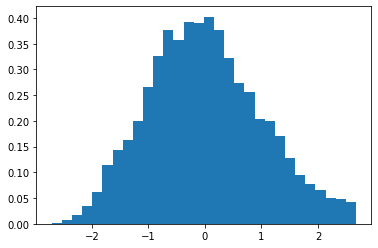

In [86]:
xs=df['usd_m2']
mean = np.mean(xs)
std = np.std(xs)
xs = [(x - mean) / std for x in xs]
plt.hist(xs,bins=30,density=True, label='usd_m2')

In [78]:
proy_final.to_excel('proy_final.xlsx')

In [83]:
df['usd_m2'].mean()

2263.0831112127753

In [84]:
df['usd_m2'].std()

649.7878029036556